<a href="https://colab.research.google.com/github/abhi-m04/CodeClause_Internship/blob/main/Price_Recommendation_for_Online_Sellers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#           Price Recommendation for Online Sellers

In [ ]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [ ]:
data=pd.read_csv('train.tsv',sep='\t')
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]
train.shape, test.shape

((29516, 8), (7541, 8))

Text(0.5, 1.0, 'Price Distribution')

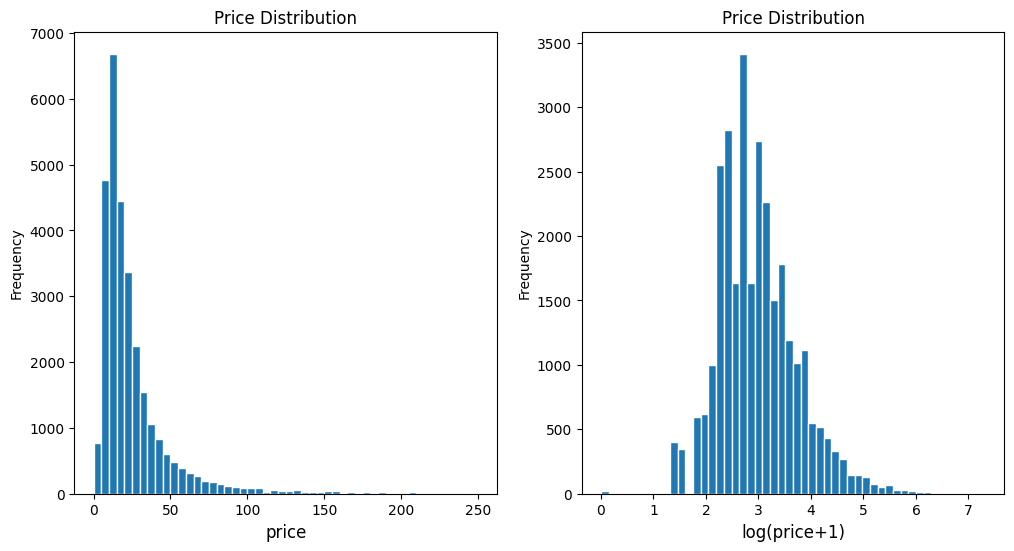

In [ ]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [ ]:
train['shipping'].value_counts() / len(train)

0    0.551023
1    0.448977
Name: shipping, dtype: float64

In [ ]:
shipping_fee_buyer = train.loc[data['shipping'] == 0, 'price']
shipping_fee_seller = train.loc[data['shipping'] == 1, 'price']
print('The mean price is {}'.format(round(shipping_fee_seller.mean(), 2)), 'when a seller pays shipping');
print('The mean price is {}'.format(round(shipping_fee_buyer.mean(), 2)), 'when a buyer pays shipping')

The mean price is 22.45 when a seller pays shipping
The mean price is 30.53 when a buyer pays shipping


<Axes: xlabel='item_condition_id', ylabel='price'>

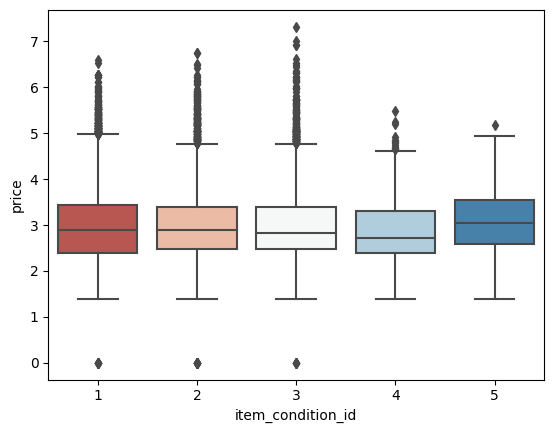

In [ ]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

# LightGBM

Helper function for LightGBM:

In [ ]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000
def handle_missing_inplace(dataset):
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].replace('No description yet,''missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [ ]:
data2 = pd.read_csv('train.tsv', sep = '\t')
msk = np.random.rand(len(data2)) < 0.8
train = data2[msk]
test = data2[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price != 0].reset_index(drop=True)

In [ ]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [ ]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [ ]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [ ]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [ ]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [ ]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

In [ ]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [ ]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [ ]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [ ]:
train_X = lgb.Dataset(X, label=y)

In [ ]:
Parameters = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

In [ ]:
GBM = lgb.train(Parameters, train_set=train_X, num_boost_round=3200, verbose_eval=100)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [ ]:
y_pred = GBM.predict(X_test, num_iteration=GBM.best_iteration)

# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.5242779977832207
